<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/BERT_MVP_V06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Disciplina Machine Learning & Analytics - Modelo Deep Learning - MVP Letra b.

**b.** Modelo baseado em Deep Learning para resolver problema de Classificação de Texto e Análise de Sentimento em Processamento de Linguagem Natural (PLN).</br>
**DataSet:** Amazon Cell Phones Reviews https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews. É uma base de avaliação de celulares, foi escolhida por questão didática para ilustrar um problema de classificação de texto e análise de sentimento. O dataset possui um conjunto de informações sobre as avaliações, como por exemplo: nome do avaliador, data, utilidade, body e rating. Para o escopo desse trabalho selecionamos 2 atributos do dataset: body e rating, sendo o body a avaliação do celular e o rating uma nota atribuída pelo avaliador que pode variar de 1 até 5, sendo 1 muito ruim e 5 excelente.</br>
**Qual é a descrição do problema?** É um problema de classificação de texto e análise de sentimento. Dado o texto de uma avaliação de celular precisamos determinar se a avaliação é positiva ou negativa.</br>
**Você tem premissas ou hipóteses sobre o problema? Quais?** Foi observado por amostragem que avaliações 1 e 2 são mais negativas enquanto 4 e 5 mais positivas. Vamos realizar a classificação com 5 classes para avaliação dos resultados, entretanto acredito que transformar o problema em uma classificação binária, para definir se a avaliação é positiva ou negativa deve apresentar uma melhor performance. </br>

In [2]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 48.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text
import warnings
warnings.filterwarnings("ignore")

# Importando DataSet Amazon Cell Phones Reviews.
Vamos trabalhar com 2 instâncias do dataset, a primeira para classificação multiclasse (df_mult) e o segundo para classificação binária. O objetivo é comparar a performance das 2 abordagens.

In [4]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/20191226-reviews.csv"

# Lê o arquivo
df_mult = pd.read_csv(url, delimiter=',', encoding='latin-1')
df_bin = pd.read_csv(url, delimiter=',', encoding='latin-1')

df_bin.head(5)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


# Preparação e pre-processamento dos Dados
Realizamos algumas operações para simplificação dos dados e adequação antes de submeter para  pre-processamento e treinamento.
*   Vamos trabalhar com um subconjunto de 10.000 registros
*   Para o dataset utilizado na classificação binária vamos adaptar a coluna "rating" da seguinte forma: os valores 1 e 2 vão ser transformados em "0", os valores 4 e 5 serão convertidos em "1" e o valor 3 "None".
*   Remover as linhas que contêm valores ausentes (NaN)
*   Redefinir os índices do DataFrame após a remoção das linhas com valores ausentes.
*   Remove caracteres especiais não reconhecidos, usando encode e decode entre os padrões ASCII e UTF-8
*   Seleciona somente as colunas "Body" e "Rating" que vão ser parte do escopo do trabalho.

In [5]:
df_mult = df_mult.head(10000)
df_bin = df_bin.head(10000)

In [6]:
mapping={1:0,2:0,3:None,4:1,5:1}
df_bin.rating=df_bin.rating.map(mapping)
df_bin=df_bin.dropna(subset='rating')

In [7]:
df_mult = df_mult.dropna()
df_mult = df_mult.reset_index(drop=True)

df_bin = df_bin.dropna()
df_bin = df_bin.reset_index(drop=True)

In [8]:
#import re
#df_bin["rating"] = df_bin["rating"].astype(int)
#df_mult["rating"] = df_mult["rating"].astype(int)

In [9]:
rat_bin=df_bin.rating.value_counts()
rat_mult=df_mult.rating.value_counts()

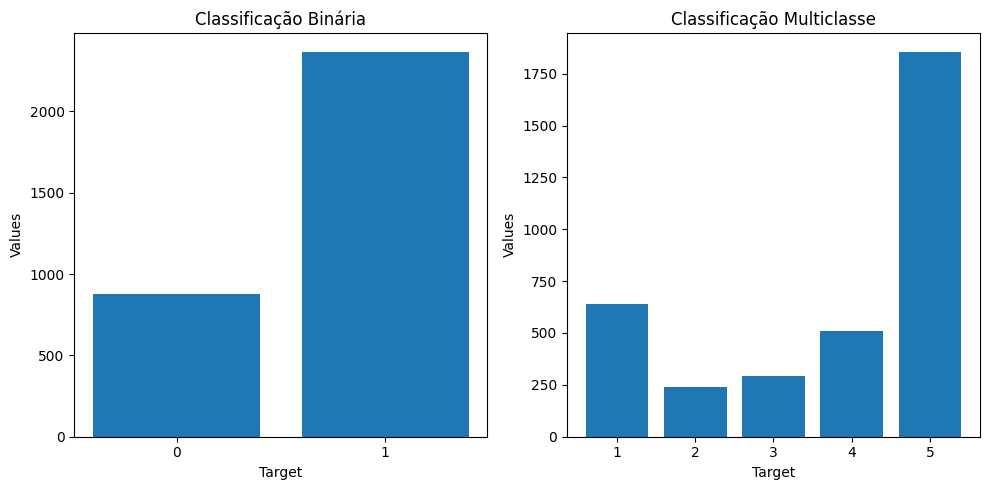

In [10]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_bin.index, rat_bin.values)
axes[0].set_xticks(rat_bin.index)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Values')
axes[0].set_title('Classificação Binária')

# Plotagem do segundo gráfico
axes[1].bar(rat_mult.index, rat_mult.values)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Values')
axes[1].set_title('Classificação Multiclasse')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

In [11]:
df_bin.loc[:, "body"] = df_bin["body"].str.encode("ascii", "ignore").str.decode("utf-8")
df_bin.loc[:, "body"] = df_mult["body"].str.encode("ascii", "ignore").str.decode("utf-8")

In [12]:
df_bin = df_bin[["body", "rating"]]
df_mult = df_mult[["body", "rating"]]
df_mult.loc[:, "rating"] = df_mult["rating"].astype(float)

In [13]:
df_mult.head(10)

,body,rating
0,I had the Samsung A600 for awhile which is abs...,3.0
1,Due to a software issue between Nokia and Spri...,1.0
2,"This is a great, reliable phone. I also purcha...",5.0
3,"I love the phone and all, because I really did...",3.0
4,The phone has been great for every purpose it ...,4.0
5,Cool. Cheap. Color: 3 words that describe the ...,5.0
6,"The 3599i is overall a nice phone, except that...",4.0
7,"I've never owned a Nokia phone before, so this...",5.0
8,ok well im in school and i need the text messa...,3.0
9,I've had this phone for over a year and I real...,4.0


# Separação em base de treino e teste

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_bin.body,df_bin.rating,test_size=0.2)
R_train, R_test, t_train, t_test = train_test_split(df_mult.body,df_mult.rating,test_size=0.2)

# Carrega o BERT preprocessor e encoder
O modelo BERT (Bidirectional Encoder Representations from Transformers) é um modelo de linguagem pré-treinado desenvolvido pelo Google que possui uma arquitetura baseada em transformers. No escopo desse trabalho o BERT foi utilizado para classificação de texto.

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
def get_sentense_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']
get_sentense_embeding([
    df_bin.body[5],df_bin.body[1]
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.66974694, -0.55856156, -0.9775242 , ..., -0.939019  ,
        -0.6770846 ,  0.6674904 ],
       [-0.78146726, -0.6098954 , -0.9507825 , ..., -0.92656064,
        -0.7495821 ,  0.5948985 ]], dtype=float32)>

In [17]:
#1 neuronio de saída com ativação sigmoid
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
model_bin=tf.keras.Model(inputs=[text_input],outputs=[l])


#Alterado para considerar as 5 classses e ativação softmax
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(5,activation='softmax',name='output')(l)
model_mult=tf.keras.Model(inputs=[text_input],outputs=[l])

In [18]:
model_bin.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [19]:
METRICS_BIN=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

METRICS_MULT=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_mult.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS_MULT)
model_bin.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS_BIN)

In [20]:
history = model_bin.fit(X_train,y_train,epochs=10)

Epoch 1/10
82/82 [==============================] - 34s 301ms/step - loss: 0.6112 - accuracy: 0.7156 - precision: 0.7232 - recall: 0.9840
Epoch 2/10
82/82 [==============================] - 25s 309ms/step - loss: 0.6071 - accuracy: 0.7218 - precision: 0.7244 - recall: 0.9941
Epoch 3/10
82/82 [==============================] - 26s 321ms/step - loss: 0.6037 - accuracy: 0.7229 - precision: 0.7251 - recall: 0.9947
Epoch 4/10
82/82 [==============================] - 28s 336ms/step - loss: 0.6041 - accuracy: 0.7222 - precision: 0.7257 - recall: 0.9910
Epoch 5/10
82/82 [==============================] - 27s 333ms/step - loss: 0.5983 - accuracy: 0.7195 - precision: 0.7243 - recall: 0.9894
Epoch 6/10
82/82 [==============================] - 27s 324ms/step - loss: 0.5962 - accuracy: 0.7256 - precision: 0.7262 - recall: 0.9973
Epoch 7/10
82/82 [==============================] - 27s 328ms/step - loss: 0.6070 - accuracy: 0.7168 - precision: 0.7244 - recall: 0.9830
Epoch 8/10
82/82 [================

In [21]:
#Converta os rótulos de classe em codificação one-hot
t_train_adjusted = t_train - 1
t_train_one_hot = tf.keras.utils.to_categorical(t_train_adjusted, num_classes=5)
#print(t_train_one_hot)

history_mult = model_mult.fit(R_train,t_train_one_hot,epochs=10)

Epoch 1/10
89/89 [==============================] - 32s 332ms/step - loss: 1.3327 - accuracy: 0.5081 - precision: 0.5720 - recall: 0.3426
Epoch 2/10
89/89 [==============================] - 29s 331ms/step - loss: 1.2660 - accuracy: 0.5389 - precision: 0.6217 - recall: 0.3702
Epoch 3/10
89/89 [==============================] - 29s 330ms/step - loss: 1.2332 - accuracy: 0.5580 - precision: 0.6475 - recall: 0.3819
Epoch 4/10
89/89 [==============================] - 29s 329ms/step - loss: 1.1969 - accuracy: 0.5679 - precision: 0.6785 - recall: 0.4052
Epoch 5/10
89/89 [==============================] - 29s 328ms/step - loss: 1.1801 - accuracy: 0.5778 - precision: 0.6821 - recall: 0.4127
Epoch 6/10
89/89 [==============================] - 29s 330ms/step - loss: 1.1592 - accuracy: 0.5817 - precision: 0.7073 - recall: 0.4264
Epoch 7/10
89/89 [==============================] - 30s 332ms/step - loss: 1.1366 - accuracy: 0.5930 - precision: 0.7035 - recall: 0.4346
Epoch 8/10
89/89 [================

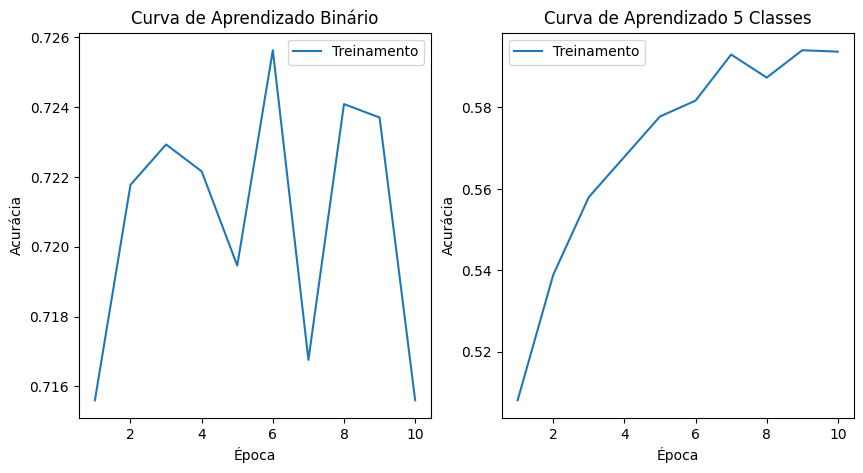

In [22]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Obtendo os scores de treinamento do histórico
train_scores_mult = history_mult.history['accuracy']
train_scores = history.history['accuracy']

# Plotando a curva de aprendizado
axes[0].plot(range(1, 11), train_scores, label='Treinamento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Aprendizado Binário')
axes[0].legend()


# Plotando a curva de aprendizado
axes[1].plot(range(1, 11), train_scores_mult, label='Treinamento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia')
axes[1].set_title('Curva de Aprendizado 5 Classes')
axes[1].legend()

plt.show()


In [23]:
model_bin.evaluate(X_test,y_test)

21/21 [==============================] - 8s 311ms/step - loss: 0.5826 - accuracy: 0.7458 - precision: 0.7458 - recall: 1.0000


[0.5825844407081604, 0.7457627058029175, 0.7457627058029175, 1.0]

In [24]:
#Converta os rótulos de classe em codificação one-hot
t_test_adjusted = t_test - 1
t_test_one_hot = tf.keras.utils.to_categorical(t_test_adjusted, num_classes=5)

model_mult.evaluate(R_test,t_test_one_hot)

23/23 [==============================] - 8s 317ms/step - loss: 1.1194 - accuracy: 0.5955 - precision: 0.7087 - recall: 0.4371


[1.1193770170211792,
 0.5954738259315491,
 0.7087156176567078,
 0.4370580017566681]

In [25]:
y_pred=model_bin.predict(X_test)
y_pred=y_pred.flatten()

21/21 [==============================] - 7s 328ms/step


In [26]:
t_pred=model_mult.predict(R_test)
#t_pred=y_pred.flatten()
print(t_pred)

23/23 [==============================] - 8s 336ms/step
[[0.10559296 0.05304169 0.08610398 0.09440609 0.6608553 ]
 [0.16845578 0.07565712 0.14355308 0.12434046 0.48799354]
 [0.19136614 0.08221278 0.13431507 0.18949927 0.40260676]
 ...
 [0.07178751 0.02975103 0.02068749 0.07668535 0.8010887 ]
 [0.06429652 0.0315055  0.05427394 0.09464655 0.7552775 ]
 [0.02248754 0.0155963  0.03893264 0.09451699 0.82846653]]


In [27]:
t_pred_classes = np.argmax(t_pred, axis=1)
#print(t_pred_classes)

In [28]:
y_pred=np.where(y_pred>0.5,1,0)
#y_pred

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
t_test = t_test - 1
cm_mult=confusion_matrix(t_test,t_pred_classes)

Text(50.722222222222214, 0.5, 'Truth')

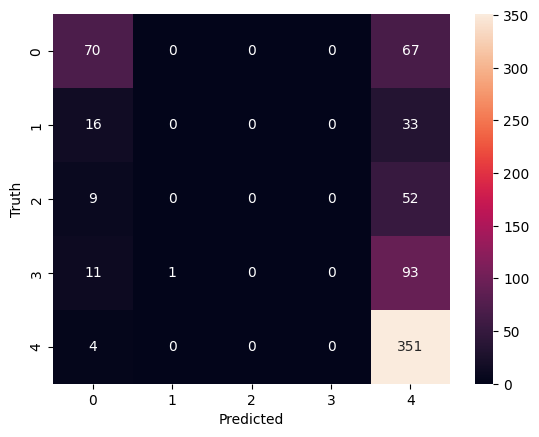

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm_mult,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [31]:
print(classification_report(t_test,t_pred_classes,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.64      0.51      0.57       137
         1.0       0.00      0.00      0.00        49
         2.0       1.00      0.00      0.00        61
         3.0       1.00      0.00      0.00       105
         4.0       0.59      0.99      0.74       355

    accuracy                           0.60       707
   macro avg       0.65      0.30      0.26       707
weighted avg       0.65      0.60      0.48       707



Text(50.722222222222214, 0.5, 'Truth')

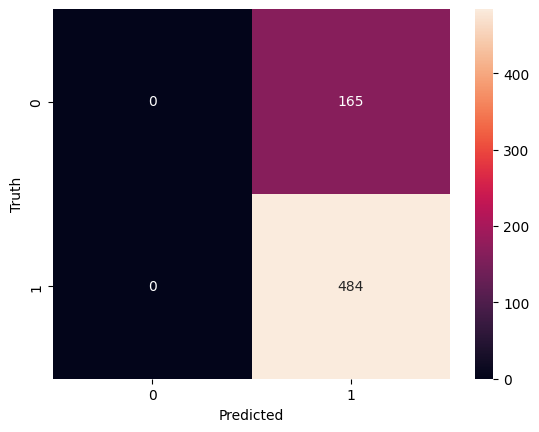

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       165
         1.0       0.75      1.00      0.85       484

    accuracy                           0.75       649
   macro avg       0.37      0.50      0.43       649
weighted avg       0.56      0.75      0.64       649



In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

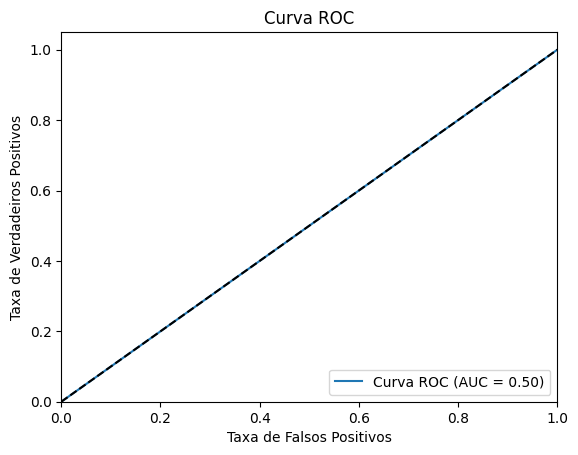

Área sob a curva (AUC): 0.5


In [35]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir o valor da AUC
print('Área sob a curva (AUC):', roc_auc)